# Model Evaluation
Evaluate the performance of BGRU and GAN models for the repective Hong Kong and United States' stock market

In [326]:
import copy
import os
import re
import numpy as np
import joblib
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, Dropout, Bidirectional
from tensorflow.keras.layers import GRU
from tensorflow.keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.metrics import Accuracy, MeanAbsoluteError, RootMeanSquaredError, MeanAbsolutePercentageError
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [327]:
EVALUATION_DIAGRAM_PATH = "./diagrams/model/evaluation"
SCALER_PATH = "./scaler"

# stocks model checkpoint paths
HK_MODELS_CHECKPOINT_PATH = "./model/hk"
US_MODELS_CHECKPOINT_PATH = "./model/us"

In [328]:
# bgru
hk_bgru_file_path = "{}/bgru.h5".format(HK_MODELS_CHECKPOINT_PATH)
hk_bgru_train_history_file_path = "{}/bgru_training_history.npy".format(HK_MODELS_CHECKPOINT_PATH)

us_bgru_file_path = "{}/bgru.h5".format(US_MODELS_CHECKPOINT_PATH)
us_bgru_train_history_file_path = "{}/bgru_training_history.npy".format(US_MODELS_CHECKPOINT_PATH)

# gan
hk_gan_file_path = "{}/gan.h5".format(HK_MODELS_CHECKPOINT_PATH)
hk_gan_train_history_file_path = "{}/gan_training_history.npy".format(HK_MODELS_CHECKPOINT_PATH)

us_gan_file_path = "{}/gan.h5".format(US_MODELS_CHECKPOINT_PATH)
us_gan_train_history_file_path = "{}/gan_training_history.npy".format(US_MODELS_CHECKPOINT_PATH)

# The model.evaluate() returns (in sequence):
## 1. loss (mean_squared_error)
## 2. mean_absolute_error
## 3. root_mean_squared_error
## 4. mean_absolute_percentage_error
evaluation_fields_name = [
    "loss (mean_squared_error)",
    "mean_absolute_error",
    "root_mean_squared_error",
    "mean_absolute_percentage_error"
]

def create_dir_if_not_exist(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname, exist_ok=True)

def is_stock_hk(stock_name):
    return ".HK" in stock_name

In [329]:
# plot diagrams function
def plot_predicted_price(predicted_y, actual_y, title, predicted_y_legend_label, actual_y_legend_label,
                                   price_currency):

    plt.figure(figsize=(14, 5), dpi=500, facecolor="white")
    plt.plot(predicted_y, label=predicted_y_legend_label)
    plt.plot(actual_y, label=actual_y_legend_label)
    plt.xlabel('Trading Day')
    plt.ylabel(price_currency)
    plt.title(title)
    plt.legend()
    create_dir_if_not_exist(EVALUATION_DIAGRAM_PATH)
    plt.savefig('{}/{}.png'.format(EVALUATION_DIAGRAM_PATH, plt.gca().get_title()))
    plt.show()

### Import datasets

In [330]:
evaluation_stocks_path = "./data/processed/stocks_for_evaluate/"
template_filename_test_x = "{}/{}_test_X.npy"
template_filename_test_y = "{}/{}_test_y.npy"

npys = [x for x in os.listdir(evaluation_stocks_path) if x.endswith('.npy')]

# get stocks name
fns = list(dict.fromkeys([
    re.sub(r'(_test_y|_test_X)', "",os.path.splitext(os.path.basename(x))[0]) for x in npys
]))

d = {}
for i in range(len(npys)):
    d[npys[i].replace(".npy", "")] = np.load(evaluation_stocks_path + npys[i])

# check if all the evaluation stock data has been imported
assert len(d) == len(fns) * 2

# Show the read files
d["AAPL_test_X"].shape

(497, 30, 9)

In [331]:
# Get the stocks' name from raw data
stock_name_hk = pd.read_csv("data/raw/HSI Constituents list_filtered.csv")
stock_name_hk = stock_name_hk[["Name", "Symbol"]]

stock_name_us = pd.read_csv("data/raw/S&P 500 Constituents_filtered.csv")
stock_name_us = stock_name_us[["Name", "Symbol"]]

stock_name_eva = pd.read_csv("data/raw/Stocks for evaluation.csv")
stock_name_eva = stock_name_eva[["Name", "Symbol"]]

stock_names = pd.concat([stock_name_us, stock_name_hk, stock_name_eva], ignore_index=True)
stock_names

,Name,Symbol
0,Wabtec,WAB
1,Ross Stores,ROST
2,UDR,UDR
3,Martin Marietta Materials,MLM
4,FMC Corporation,FMC
...,...,...
95,CHINA LIFE,2628.HK
96,CM BANK,3968.HK
97,BANK OF CHINA,3988.HK
98,Standard Chartered PLC,2888.HK


### Import scaler

In [332]:
joblibs = [x for x in os.listdir(SCALER_PATH) if x.endswith('.joblib')]

# get scaler names
scaler_names = [os.path.splitext(os.path.basename(x))[0] for x in joblibs]

scalers = {}

for i in range(len(scaler_names)):
    scalers[scaler_names[i]] = joblib.load(SCALER_PATH + "/" + joblibs[i])

# Show the read scaler
print(scalers["{}.X_scaler".format("1038.HK")])
print(scalers["{}.y_scaler".format("1038.HK")])

MinMaxScaler(feature_range=(-1, 1))
MinMaxScaler(feature_range=(-1, 1))


### Import models

In [333]:
hk_bgru = load_model(hk_bgru_file_path)
# hk_gan = load_model(hk_gan_file_path)
# us_bgru = load_model(us_bgru_file_path)
# us_gan = load_model(us_gan_file_path)


### Predicts and evaluate the stocks

In [334]:
df_eva_metrics = pd.DataFrame(
    columns=["model", "stock"] + evaluation_fields_name
)

In [335]:
def predict_and_evaluate(model, model_name, is_model_hk):
    """
    Predict and evaluate the model with stocks
    :param model: tf.Keras.Model
    :param model_name:  str, model name
    :param is_model_hk: boolean, indicates whether the model is trained for HK market
    """
    global df_eva_metrics
    for i in range(len(fns)):
        tmp_stock = fns[i]

        tmp_eva_result = model.evaluate(x=d["{}_test_X".format(tmp_stock)], y=d["{}_test_y".format(tmp_stock)])
        tmp_predict_result = model.predict(x=d["{}_test_X".format(tmp_stock)])
        tmp_scaler_y = scalers["{}.y_scaler".format(tmp_stock)]

        plot_predicted_price(
            predicted_y=tmp_scaler_y.inverse_transform(
                tmp_predict_result
            ),
            actual_y=tmp_scaler_y.inverse_transform(
                d["{}_test_y".format(tmp_stock)]
            ),
            # title="CK Infrastructure Holdings Limited (1038.HK) Stock Price Prediction with BGRU",
            title="{} ({}) Stock Price Prediction with {} {}".format(
                stock_names[stock_names["Symbol"] == tmp_stock]["Name"].item(),
                tmp_stock,
                "HK" if is_model_hk else "US",
                model_name
            ),
            predicted_y_legend_label="{} Predicted Closing Price".format(model_name),
            actual_y_legend_label="Actual Closing Price",
            price_currency="HKD" if is_stock_hk(tmp_stock) else "USD"
        )

        # df_eva_metrics = df_eva_metrics.append(
        #     [model_name, tmp_stock] + tmp_eva_result
        # )

#### HK models (BGRU & GAN) predicting the stocks
##### BGRU

15/15 [==============================] - 1s 20ms/step - loss: 0.0100


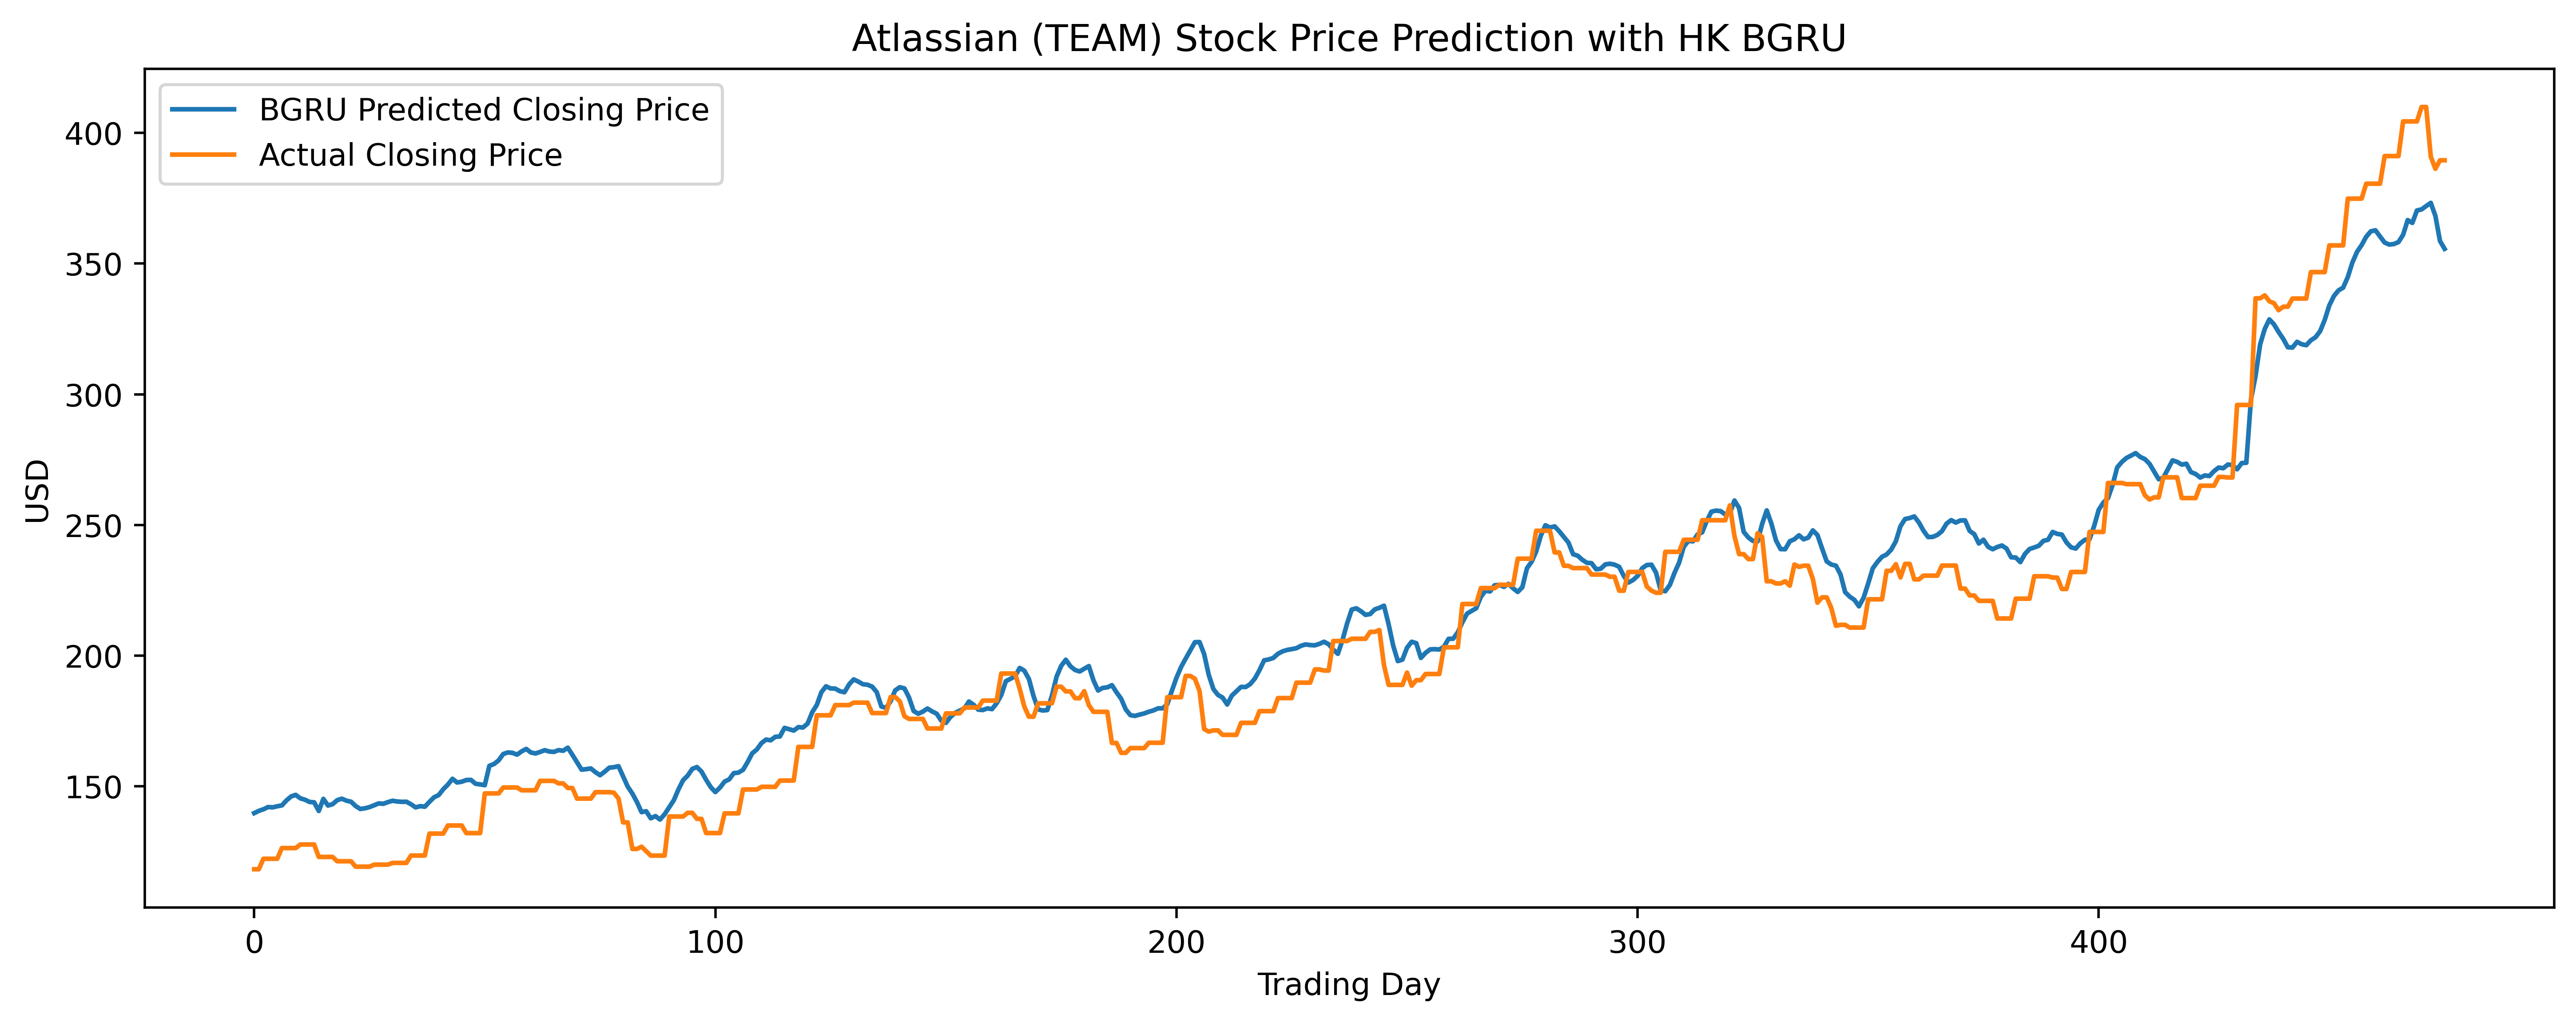

15/15 [==============================] - 0s 16ms/step - loss: 0.0210


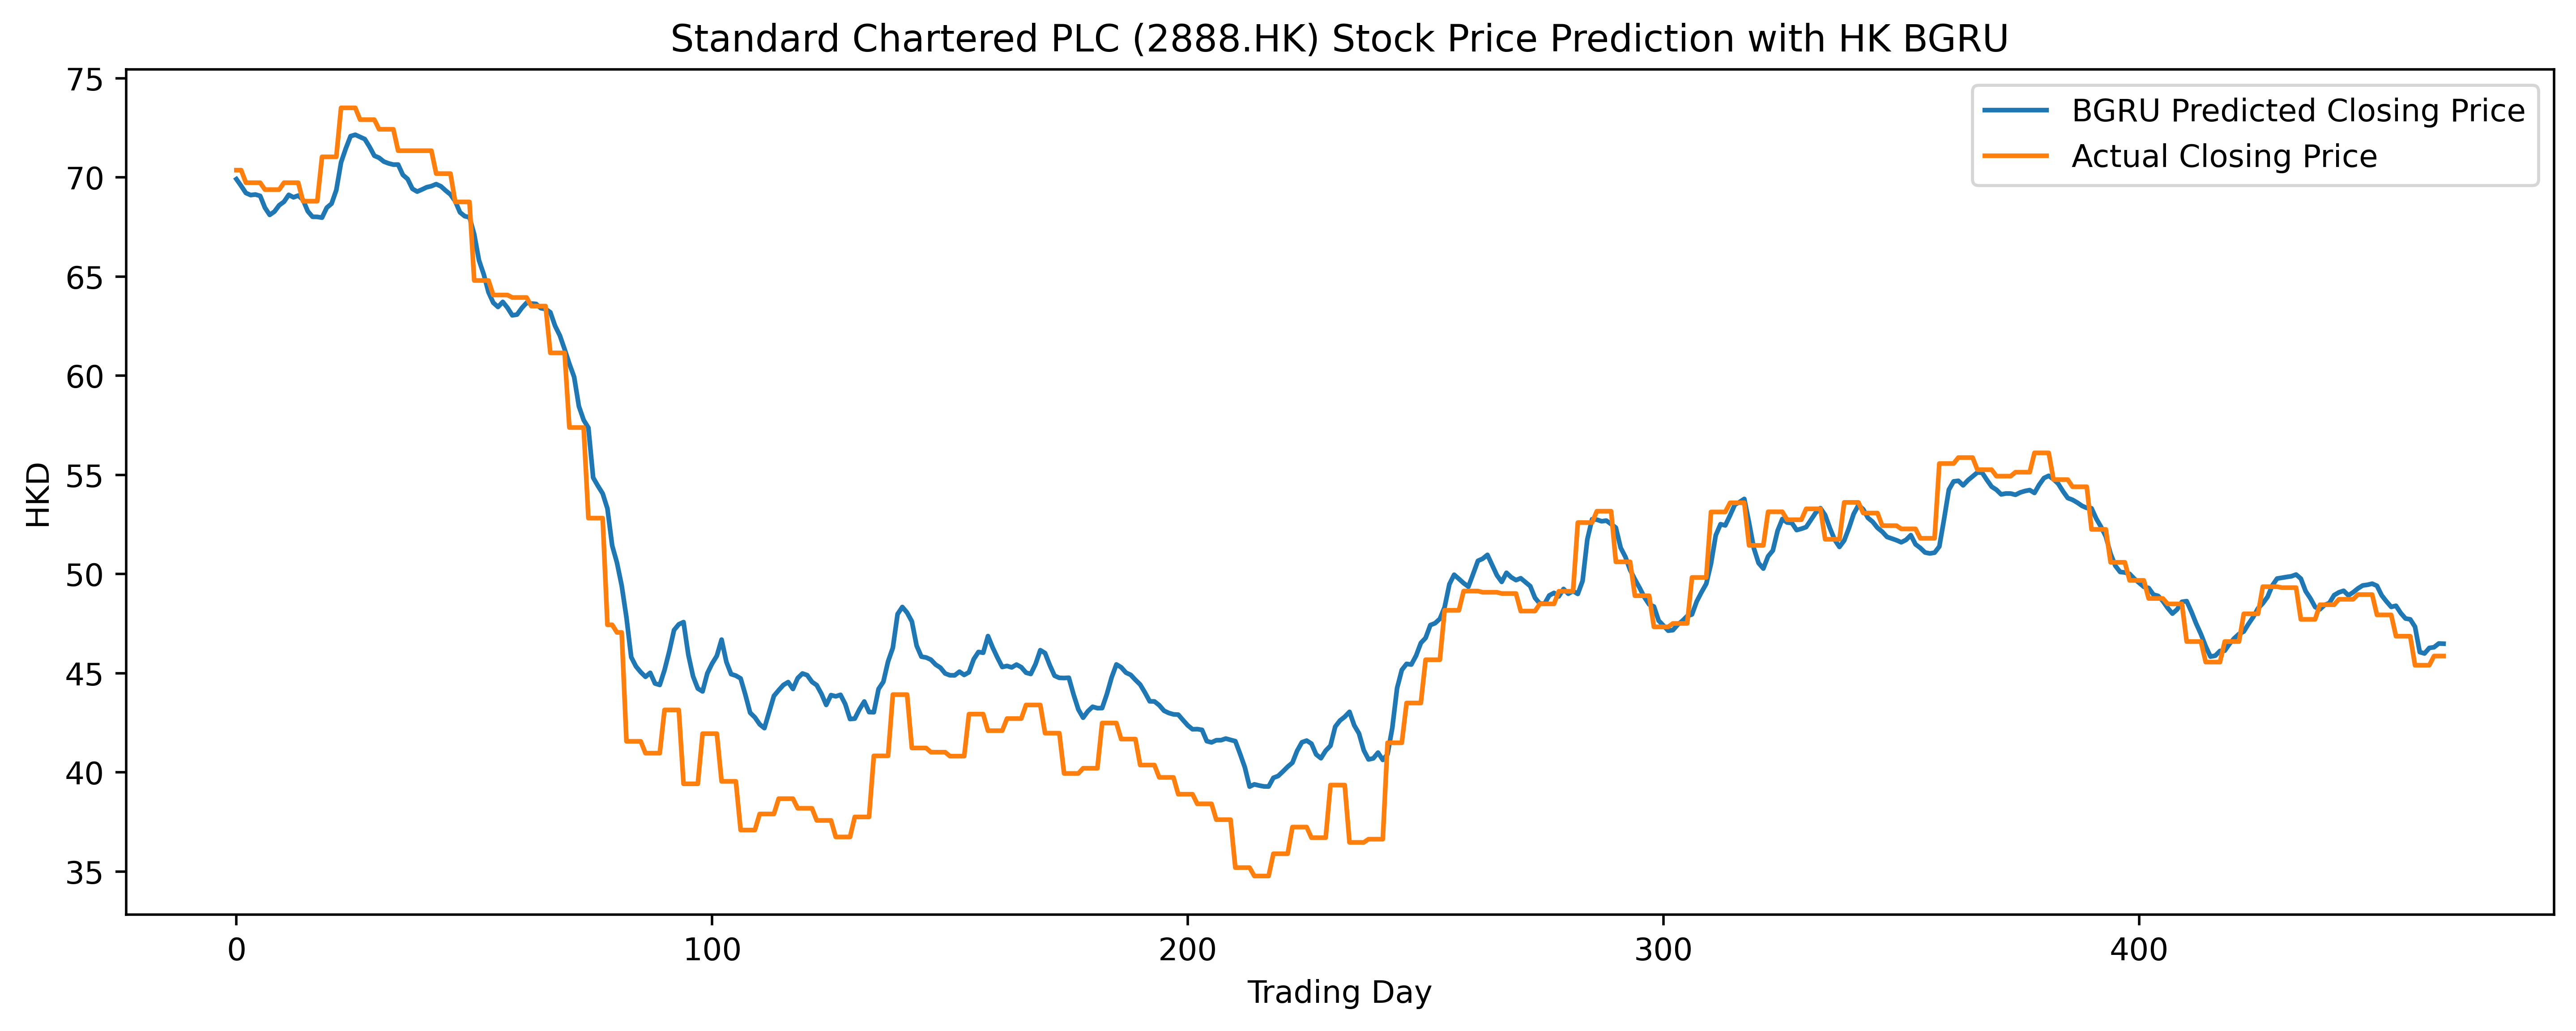

16/16 [==============================] - 0s 14ms/step - loss: 0.0016


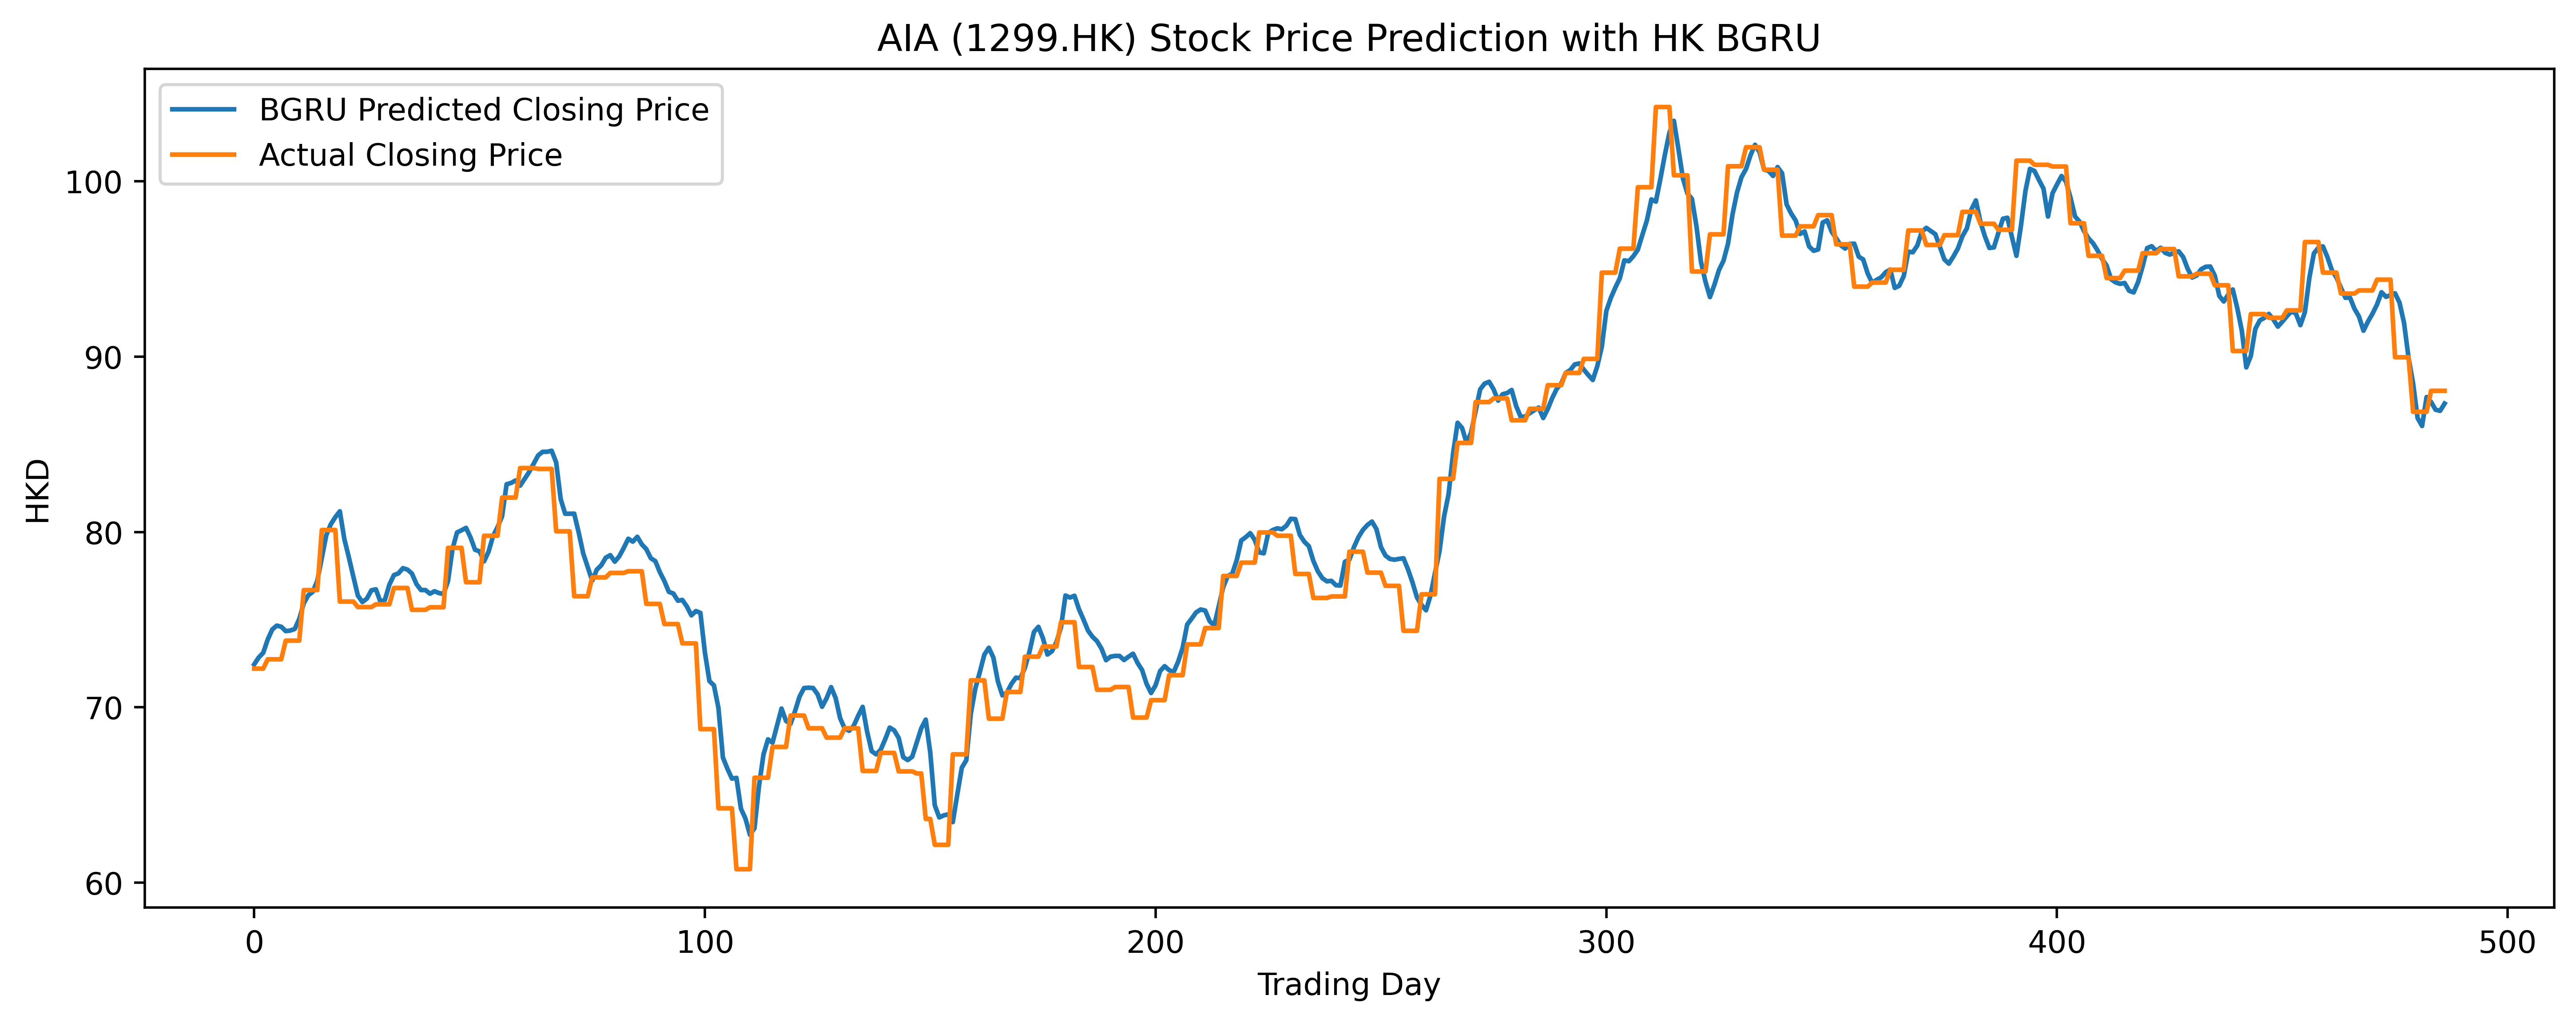

16/16 [==============================] - 0s 9ms/step - loss: 0.0017


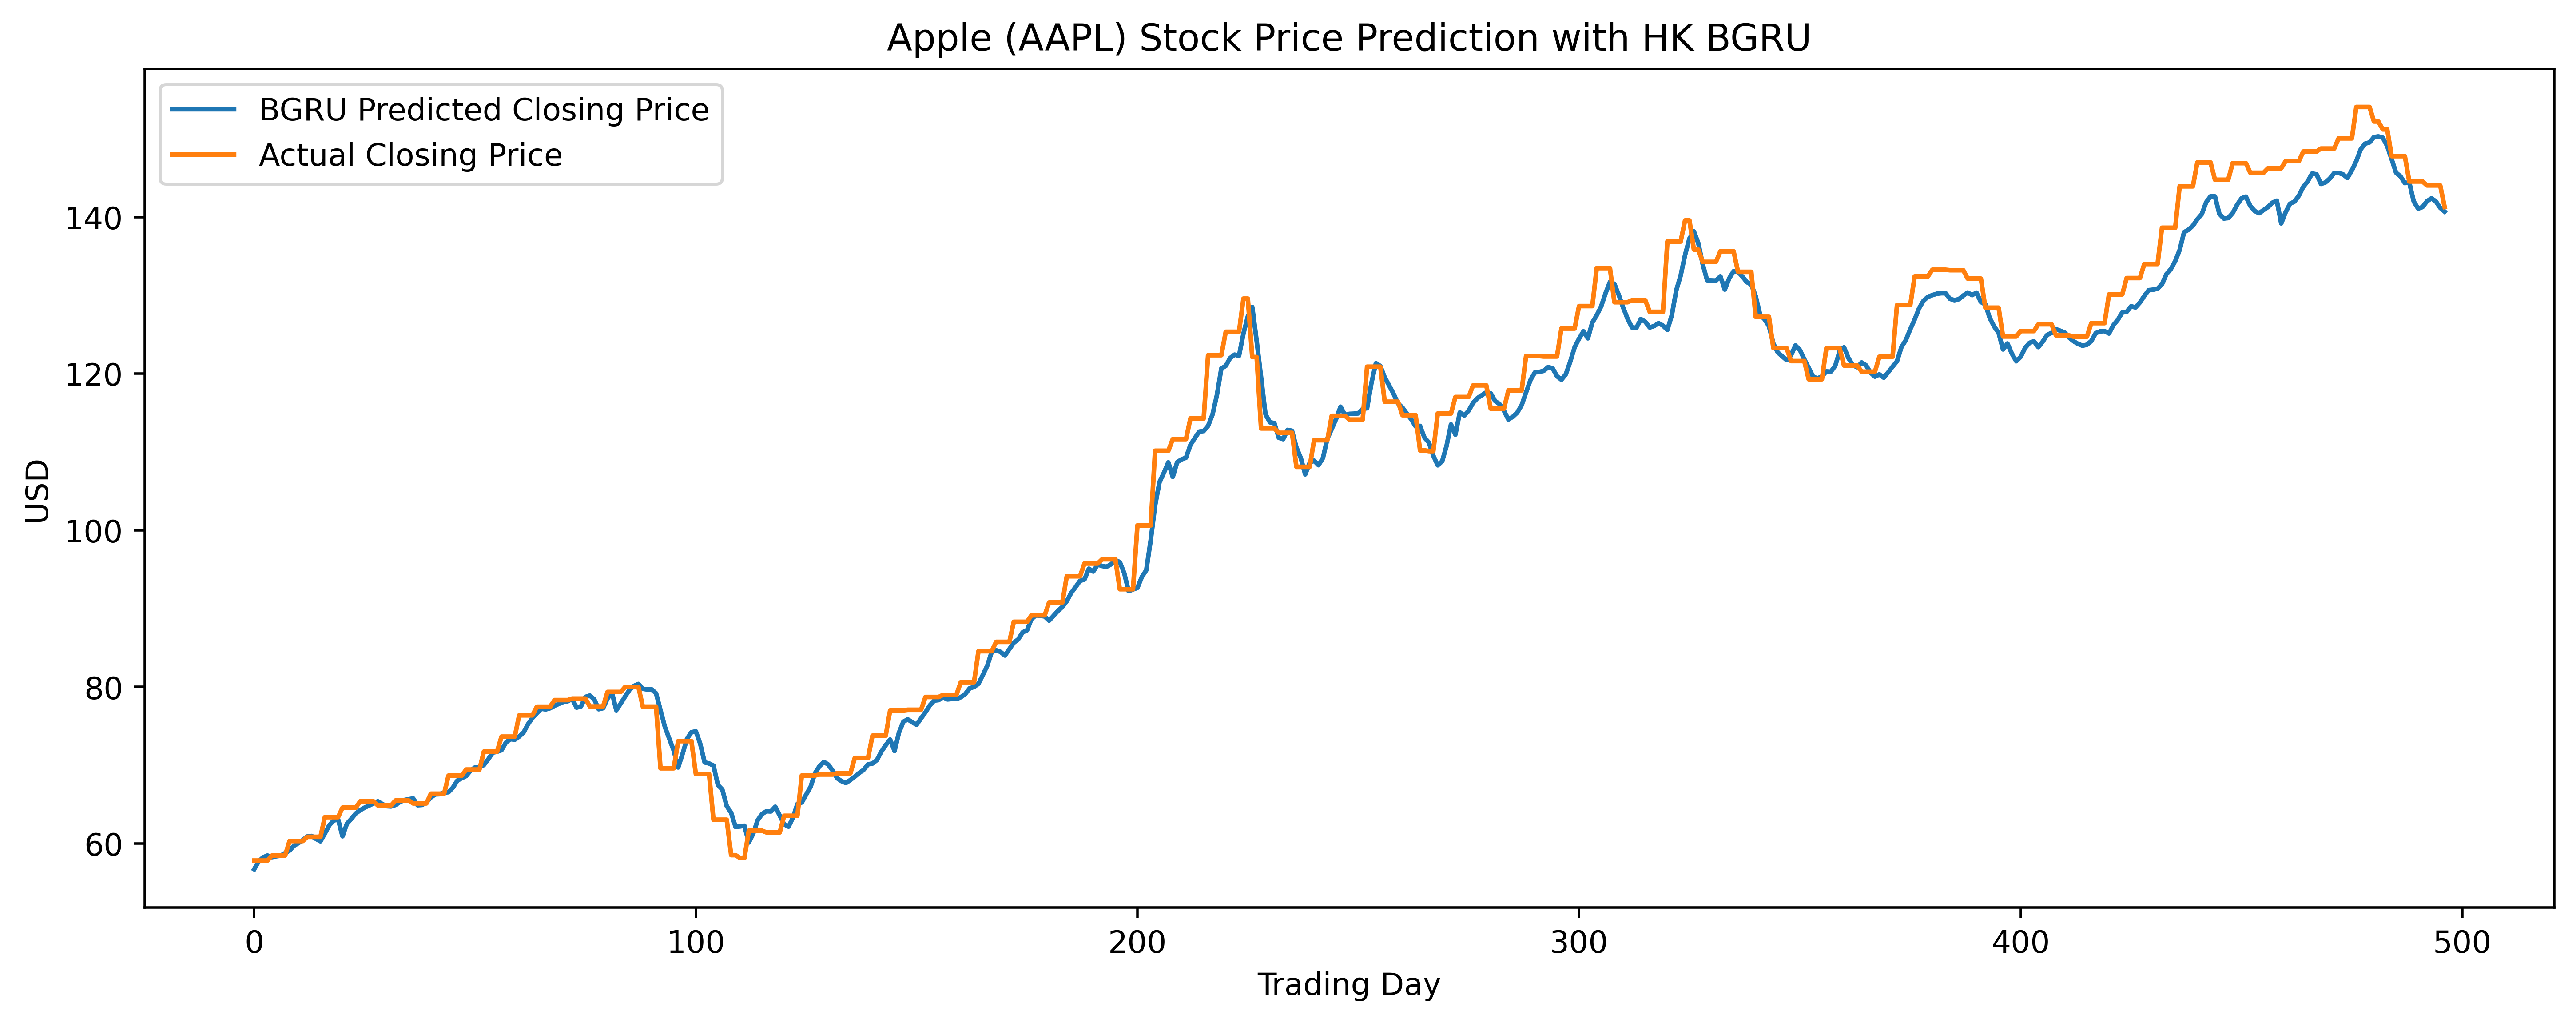

16/16 [==============================] - 0s 10ms/step - loss: 0.0249


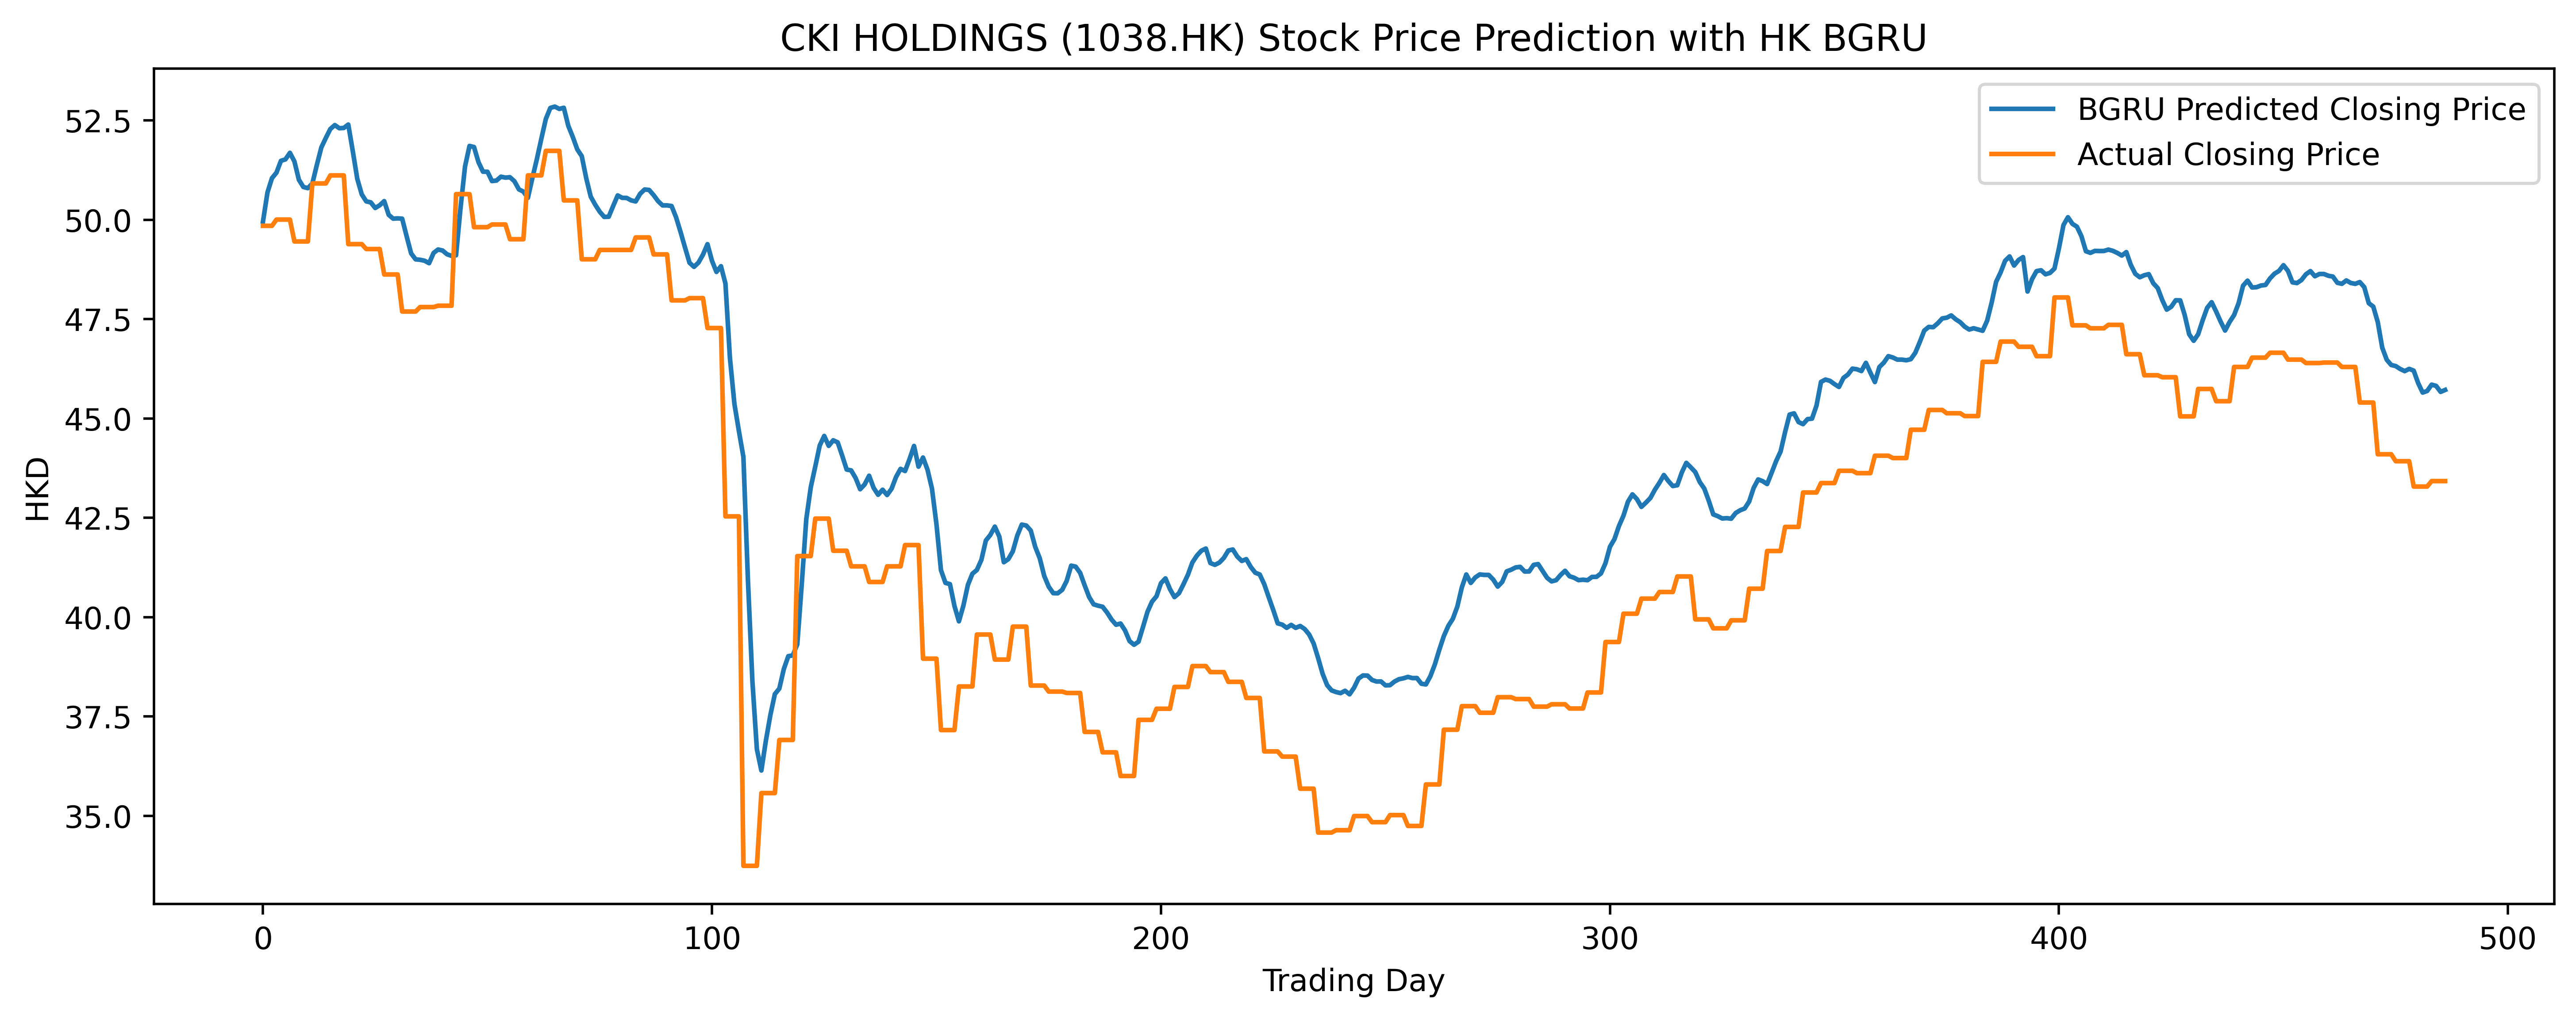

16/16 [==============================] - 0s 10ms/step - loss: 9.2926e-04


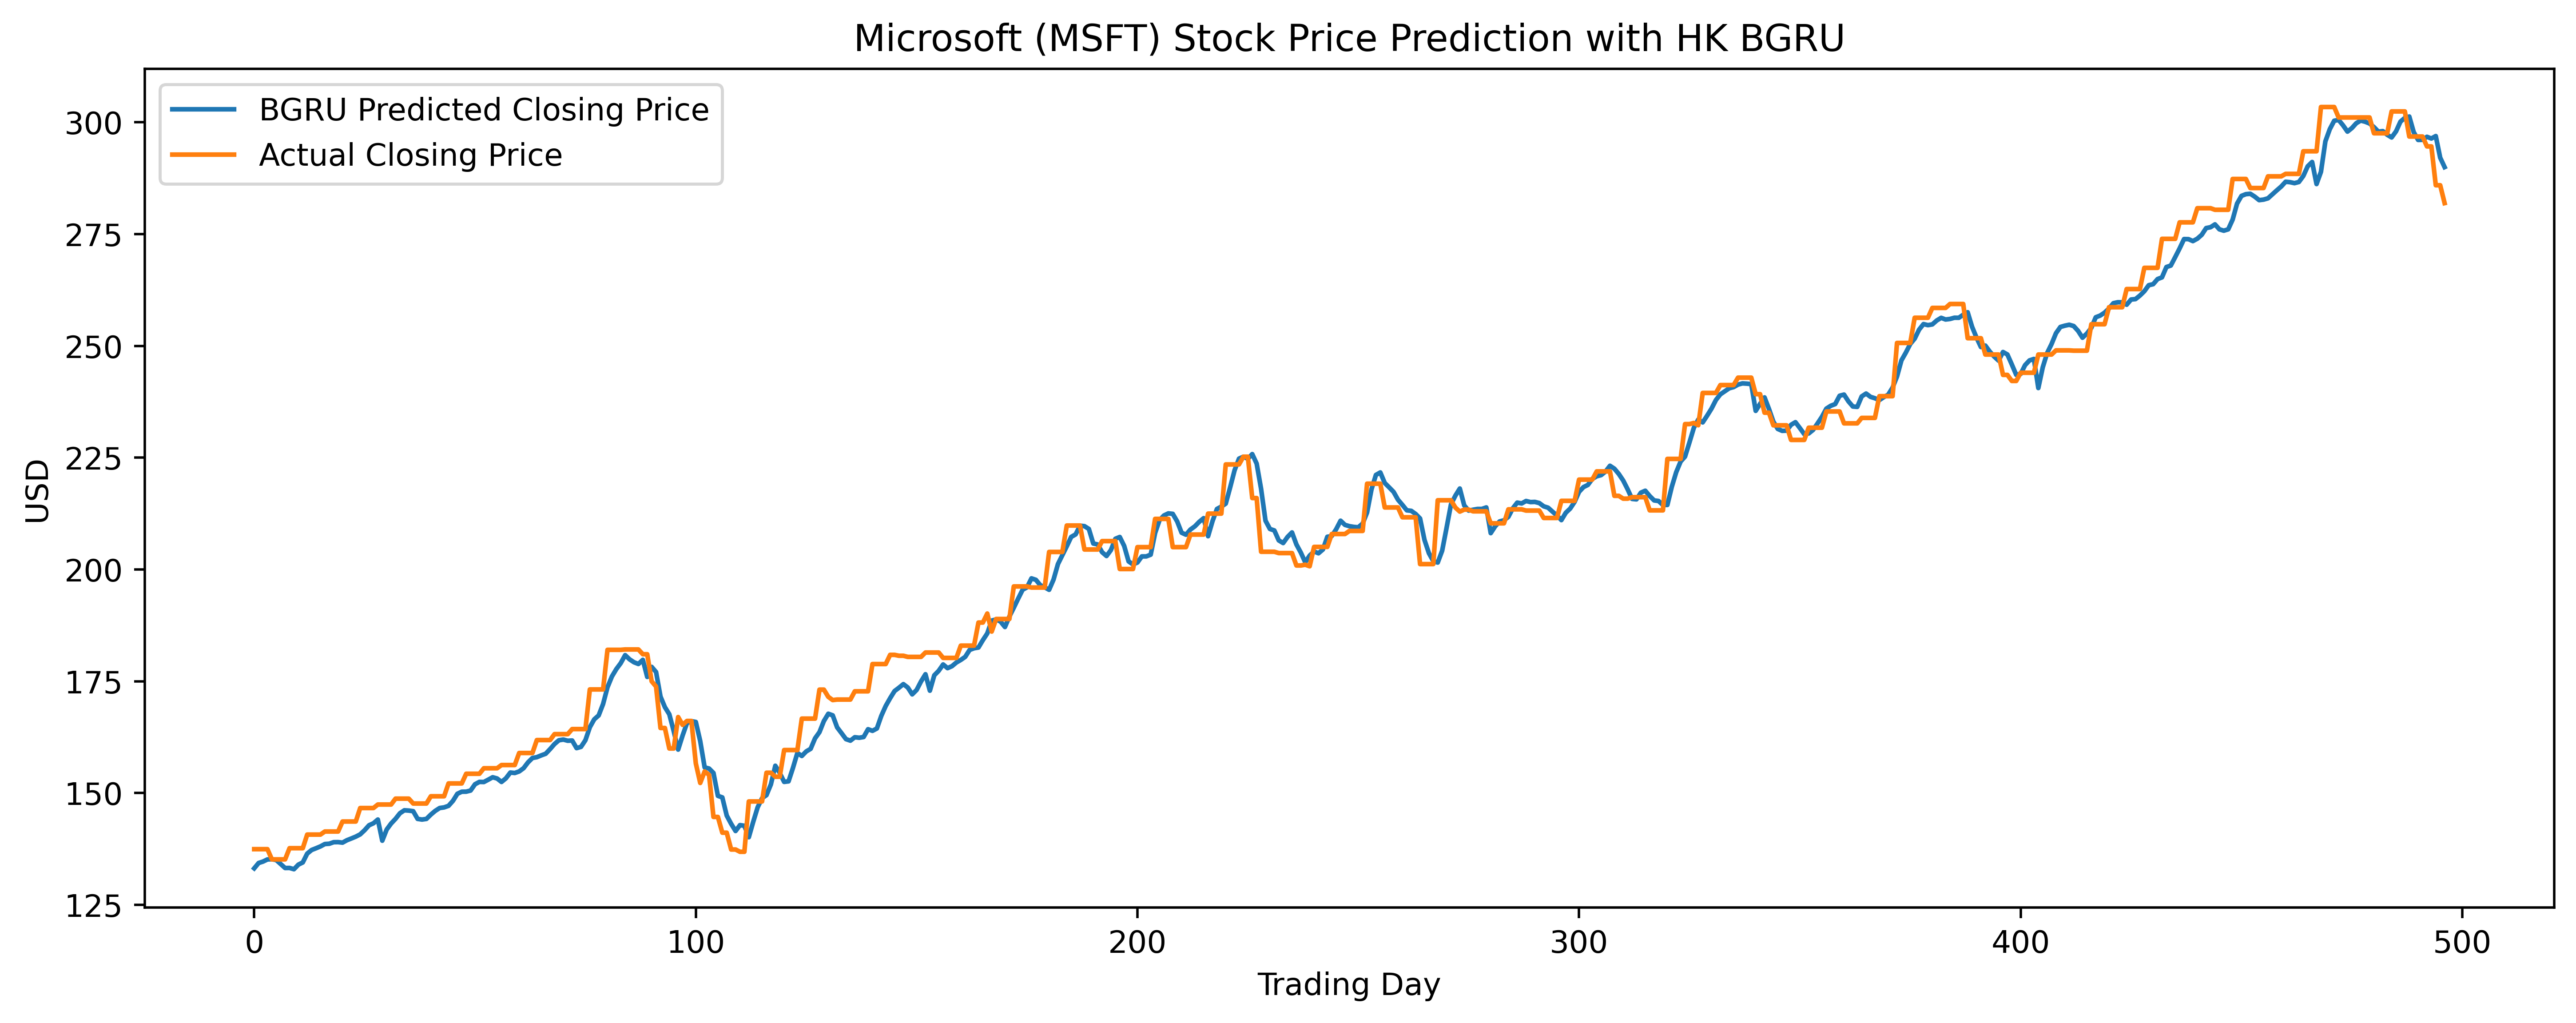

In [336]:
predict_and_evaluate(hk_bgru, "BGRU", True)

##### GAN

In [337]:
predict_and_evaluate(hk_gan, "GAN", True)

NameError: name 'hk_gan' is not defined

#### US models (BGRU & GAN) predicting the stocks
##### BGRU

In [ ]:
predict_and_evaluate(us_bgru, "BGRU", False)

##### GAN

In [ ]:
predict_and_evaluate(us_gan, "GAN", False)

#### Display the Dataframe of evaluation metrics

In [ ]:
df_eva_metrics